# X 389.5

#### Numerically set threshold and then minimize probabilitites of misscounts. 

In [121]:
import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import stats
import scipy.stats
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import glob
import time
import pandas as pd
import math
#import File_functions
plt.rcParams["figure.figsize"] = (3,3)
print (time.ctime())

Sun Nov 28 06:19:05 2021


In [122]:
def One(x,y,x2,y2,file,plot,afterpulse_control = True):
    
    One.filename = file
    x1,y1=x,y
    x2,y2=x2,y2

    old_data_table = pd.read_csv(f'{filename}')
    old_data_table = old_data_table.drop(columns = 'Unnamed: 0')
    old_data_table['time'] = ((25*old_data_table['time'])/(4096)) #Output in ns
    One.old_data_table=old_data_table
    
    R = 2
    R1 = R
    Ion_1 = (
        old_data_table.query(f"((x-{x1})**2 + (y-{y1})**2)**(1/2) <= {R1}")
        .reset_index(drop=True)
    )
    name = Ion_1
    dt = []
    for i in range(0, len(name)-1):
        dt.append(name.at[i+1, 'time'] - name.at[i, 'time'])
    dt.insert(0,0)
    Ion_1['dt'] = dt
    
    if afterpulse_control:
        Ion_1.query(f' dt > 1e-7', inplace = True) # eliminate after pulsing effects, this prevents breaks in dark states, and peaks at 0(s) bright states
        Ion_1.reset_index(inplace = True)
    Ion_1['index'] = np.arange(len(name))
    
    ## Dark Region referred to as "Dark Ion"
    
    dark_Ion_1 = (
        old_data_table.query(f"((x-{x2})**2 + (y-{y2})**2)**(1/2) <= {R1}")
        .reset_index(drop=True)
    )
    name = dark_Ion_1
    dt = []
    for i in range(0, len(name)-1):
        dt.append(name.at[i+1, 'time'] - name.at[i, 'time'])
    dt.insert(0,0)
    dark_Ion_1['dt'] = dt
    
    if afterpulse_control:
        dark_Ion_1.query(f' dt > 1e-7', inplace = True) # eliminate after pulsing effects, this prevents breaks in dark states, and peaks at 0(s) bright states
        dark_Ion_1.reset_index(inplace = True)
    dark_Ion_1['index'] = np.arange(len(name))
    
    One.data_table = Ion_1
    data_table= Ion_1
    dark_data_table=dark_Ion_1
    One.dark_data_table=dark_Ion_1
    One.ion_1=Ion(1, x,x2, y,y2, R, Ion_1,dark_Ion_1,debugPrinting=False)
     
    if plot==True:
        fig, (ax1, ax2,ax3) = plt.subplots(ncols = 3, figsize = (12, 4))
        ax1.hist2d(old_data_table['x'], old_data_table['y'], range = [(min(data_table['x'])-2, max(data_table['x'])+2), (min(data_table['y'])-2, max(data_table['y'])+2)], bins = (int(max(data_table['x']) - min(data_table['x']) +5) , int(max(data_table['y']) - min(data_table['y']) +5)))
        ax2.hist2d(data_table['x'], data_table['y'], range = [(min(data_table['x'])-2, max(data_table['x'])+2), (min(data_table['y'])-2, max(data_table['y'])+2)], bins = (int(max(data_table['x']) - min(data_table['x']) +5) , int(max(data_table['y']) - min(data_table['y']) +5)))
        ax3.hist2d(dark_data_table['x'], dark_data_table['y'], range = [(min(dark_data_table['x'])-2, max(dark_data_table['x'])+2), (min(dark_data_table['y'])-2, max(dark_data_table['y'])+2)], bins = (int(max(dark_data_table['x']) - min(dark_data_table['x']) +5) , int(max(dark_data_table['y']) - min(dark_data_table['y']) +5)))
        ax1.set_title("Full Data")
        ax2.set_title("True Ion ROI")
        ax3.set_title(f'ROI @x={x2}')
        plt.show()

In [123]:
class Ion:
    def __init__(self, n, x,x2, y,y2, r0,data,dark_data, debugPrinting=False):
        self.filename=One.filename
        self.n = n # Ion number (left to right)
        self.x = x # Ion x-position
        self.y = y # Ion y-position
        self.r0 = r0 # Ion radius
        
        #Dark ROI parameters 
        self.x2 = x2 # dark x-position
        self.y2= y2 # dark y-position
        self.r2 = r0 # dark radius (Same as Ion's)
 
        self.data = data # Dataframe used (data_table in choose_file)
        self.dark_data = dark_data #Dataframe for dark ROI 
        
        self.threshold = [] # differentiator between bright/dark states by 'dt' between events in ROI
        
        self.bright = [] # stores data for only bright events
        self.dark = [] # stores data for only dark events
        
        self.transpts = []  # Transition points (index number)
        # DtB = dark to bright
        # BtD = bright to dark
        self.tofBright=[]  
        self.tofDark=[]
        self.dtDark=[]
        self.dtBright=[]
        self.DtB = []
        self.BtD = []
        self.brightRanges = []

# auto_threshold finds threshold dt where sum of (area of dark ion to the left of threshold ) and (area of true ion
  # to the right of threshold) is minimal. 
    
    def auto_threshold(self,sigma, uncertainty_control ): 
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 3))
                bin_heights, bin_borders, _ = ax1.hist(self.data['dt'], bins = 'auto', range = (0, 1e7), alpha = .5, label=(f'Ion {self.n}'), density = True)
                dark_heights, dark_borders, _ = ax1.hist(self.dark_data['dt'], bins = bin_borders, range = (0, 1e7), alpha = .5, label=(f'Dark @x= {self.x2}'), density = True) 
                                #dark bins same as true ion bins to locate threshold. 
                bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
                ax1.set_yscale('log')      
                 
                # Display parameters 
                ax1.set_title(f'{filename} Ion #{self.n}')
                ax1.set_ylabel(f'Probability (log-base)');
                ax1.set_xlabel(f'Time between events in ROI (ns)')

                # This part determines the theshold for the Bright/Dark state detection by minimizing area of overlap. 
                width=bin_centers[1]-bin_centers[0]
                summ=[]
                for i in range (len(bin_centers)):
                    summ.append((sum(dark_heights[:i])*width)+(sum(bin_heights[i:])*width))
                idx=np.array(summ).argmin()    #index of smallest value in "sum"
                threshold=bin_centers[idx] # in  ns
                
                ax1.legend()
                ax1.axvline(threshold)

                print(f'Ion {self.n} ; threshold: {threshold*1e-9}(s)' )
             
                #Plot everything on a non-log base y-scale. 
                ax2.hist(self.data['dt'], bins = 'auto', range = (0, 1e7), alpha = .5, label=(f'Ion {self.n}'), density = True)
                ax2.hist(self.dark_data['dt'], bins = bin_borders, range = (0, 1e7), alpha = .5, label=(f'Dark @x= {self.x2}'), density = True)
                bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
                ax2.set_title(f'{filename} Ion #{self.n}')
                ax2.set_ylabel(f'Probability')
                ax2.set_xlabel(f'Time between events in ROI (ns)')
                ax2.axvline(threshold,label="Thresold")
                ax2.set_ylim(0,bin_heights.max()*1.05)
        
                ax2.legend()
                fig.tight_layout()

                self.threshold = threshold
                
    def sortbythreshold(self, uncertainty_control = False): #Sorts true ion into dark and bright regions 
        
            self.bright = self.data.query(f'dt < {self.threshold}')
            self.dark = self.data.query(f'dt > {self.threshold}')
 
    def transitions(self, single_photon_control = True):
       
        # identifies points where quantum jumps happen using list comprehension
        misscount = 0
        self.transpts.clear()
        for i in range(len(self.data)) :
            if i not in self.bright['index']:
                misscount = misscount + 1
                if misscount == 1:
                    self.transpts.append(i)
            if i in self.bright['index'] and misscount >= 1:
                misscount = 0
                self.transpts.append(i)
        
        
                
        # DtB = dark to bright
        # BtD = bright to dark
        self.DtB.clear()
        self.BtD.clear()
        for i in range(len(self.transpts)):
            if self.transpts[i] in self.bright['index']:
                self.DtB.append(self.transpts[i])
            else:
                self.BtD.append(self.transpts[i])
                
    def setup(self,kind,sigma, uncertainty_control, single_photon_control):
        
        if kind=="auto":
            self.auto_threshold(sigma,uncertainty_control)
            self.sortbythreshold(uncertainty_control)
            self.transitions(single_photon_control)
        elif kind=="integration":
            self.FindBrightRangesPrecise(arrT,N)
            
    def visRange(self, start, duration):
        
        # plots a small slice of data 
        # and uses red/blue color coding to distinguish between the bright and dark state
        # useful for visualizing the effects of different sorting methods
        
        end = start+duration # index values
        use = self.data.query(f'{start} <= index < {end}')
        index = use.index
        change = use['dt']
        linehere = []
        for j in index:
            if j in self.transpts:
                linehere.append(j)
        
        plt.figure(figsize=(15, 1.5))
        counting = index
        plt.scatter(counting, change)
        plt.title("Visual representation of ion states")
        plt.xlabel("Time (s)")
        plt.ylabel("time between photons (s)")
        plt.ylim(-15,25*self.threshold)

        if linehere != []:
            
            if index[0] in self.dark['index']:
                if index[0] in self.transpts:
                    plt.axvspan(self.data.at[index[0], 'index'], self.data.at[linehere[0], 'index'], alpha=0.3, color='blue')
                    plt.axvspan(start, self.data.at[index[0], 'index'], alpha=0.3, color='red',label="Bright")
                else:
                    plt.axvspan(start, self.data.at[linehere[0], 'index'], alpha=0.3, color='blue',label="Dark")
            if index[0] in self.bright['index']:
                if index[0] in self.transpts:
                    plt.axvspan(self.data.at[index[0], 'index'], self.data.at[linehere[0], 'index'], alpha=0.3, color='red')
                    plt.axvspan(start, self.data.at[index[0], 'index'], alpha=0.3, color='blue')
                else:
                    plt.axvspan(start, self.data.at[linehere[0], 'index'], alpha=0.3, color='red')

            if index[-1] in self.bright['index']:            
                plt.axvspan(self.data.at[linehere[-1], 'index'], end, alpha=0.3, color='red')
            if index[-1] in self.dark['index']:
                plt.axvspan(self.data.at[linehere[-1], 'index'], end, alpha=0.3, color='blue')
                
            for i in range(len(linehere)):
                plt.axvline(x=linehere[i])
            for i in range(len(linehere) - 1):
                if linehere[i] in self.DtB:
                    plt.axvspan(self.data.at[linehere[i], 'index'], self.data.at[linehere[i+1], 'index'], alpha=0.3, color='red')
                if linehere[i] in self.BtD:
                    plt.axvspan(self.data.at[linehere[i], 'index'], self.data.at[linehere[i+1], 'index'], alpha=0.3, color='blue')
            
            
        if linehere == []:
            if len(use) == (0 or 1):
                print(f'Ion {self.n} had {len(use)} hits during this time')
                plt.axvspan(start, end, alpha=0.3, color='blue')
            else:
                if index[0] in self.dark['index']:
                    plt.axvspan(self.data.at[index[0], 'index'], self.data.at[index[-1], 'index'], alpha=0.3, color='blue')
                else:
                    plt.axvspan(self.data.at[index[0], 'index'], self.data.at[index[-1], 'index'], alpha=0.3, color='red')
            plt.axvspan(self.data.at[index[-1], 'index'], end, alpha=0.3, color='blue')
            plt.axvspan(start, self.data.at[index[0], 'index'], alpha=0.3, color='blue')
            
        plt.xlim(start,end) 
        plt.axhline(self.threshold)
        plt.legend()
        plt.show()
        

## Section 1

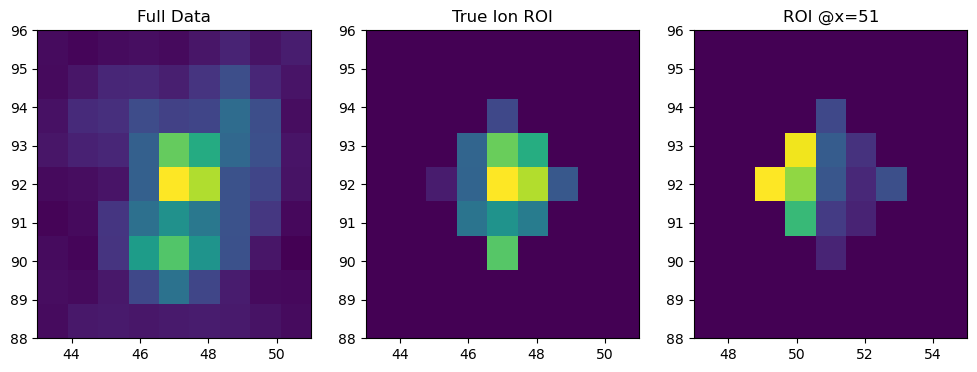

In [124]:
filename='../P/x_389.5'
One(x=47,y=92,x2=51,y2=92,file=filename,plot=True) # x=47; y=92 (Actual Ion)

In [125]:
ion_1=One.ion_1 #ROI of ion centered at x=47

Ion 1 ; threshold: 0.0020695970695970697(s)


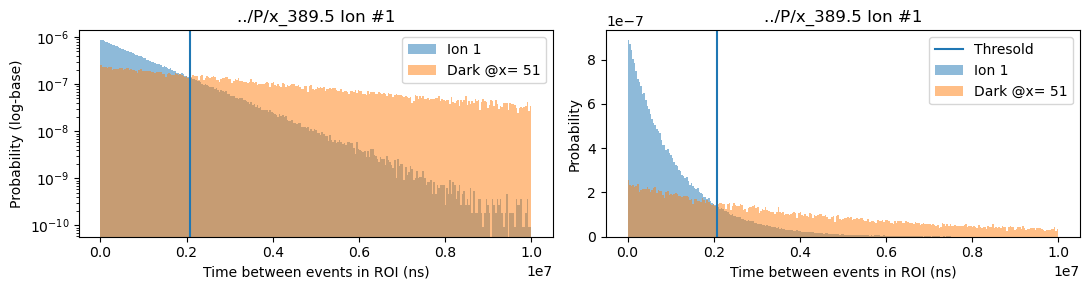

In [126]:
sigma,uncertainty_control,single_photon_control=2,False,True
ion_1.setup("auto",sigma, uncertainty_control, single_photon_control)

In [127]:
time=(max(One.data_table['time'])-min(One.data_table['time']))*1e-9  #converting to seconds
rate=(len(ion_1.transpts))/time
print ("#Transitions:",len(ion_1.transpts),"\nRate (s):",rate)

#Transitions: 78755 
Rate (s): 129.59292665649357


### Section 2:
Ignore this section ; Nov. 27 2021

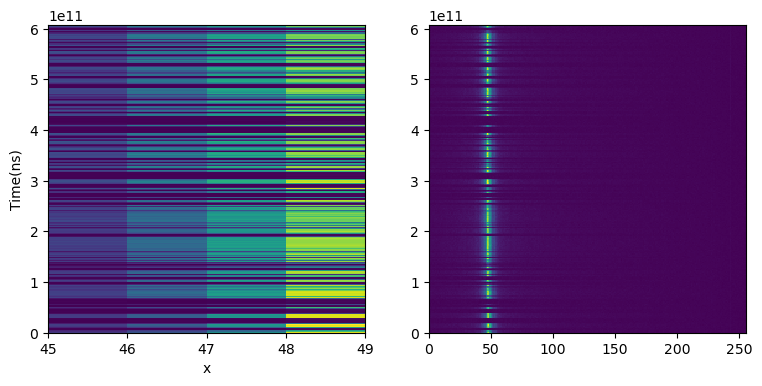

In [128]:
# This cell plots the telegraph on the left and times where transition occurs. 

fig,(ax,ax2)=plt.subplots(1,2,figsize=(9,4))
h,bx,by,im=ax.hist2d(One.old_data_table["x"],One.old_data_table["time"],range=[[45,49],[0,max(One.old_data_table["time"])]],bins=([45,46,47,48,49],340))
ax2.hist2d(One.old_data_table["x"],One.old_data_table["time"],bins=256)
#ax2.hlines(h_lines["time"],0,max(One.old_data_table["x"]),colors="white",lw=0.3,ls="--")
#ax.set_ylim(0,5e8)
#ax2.set_ylim(0,5e8)
ax.set_xlabel("x")
ax.set_ylabel("Time(ns)")
#ax.set_xlim(0,100)
#ax2.set_xlim(0,100)
plt.show()

In [129]:
bx_centers=(bx[1:]+bx[:-1])/2
bx_centers

array([45.5, 46.5, 47.5, 48.5])

Text(0.5, 1.0, 'x=47')

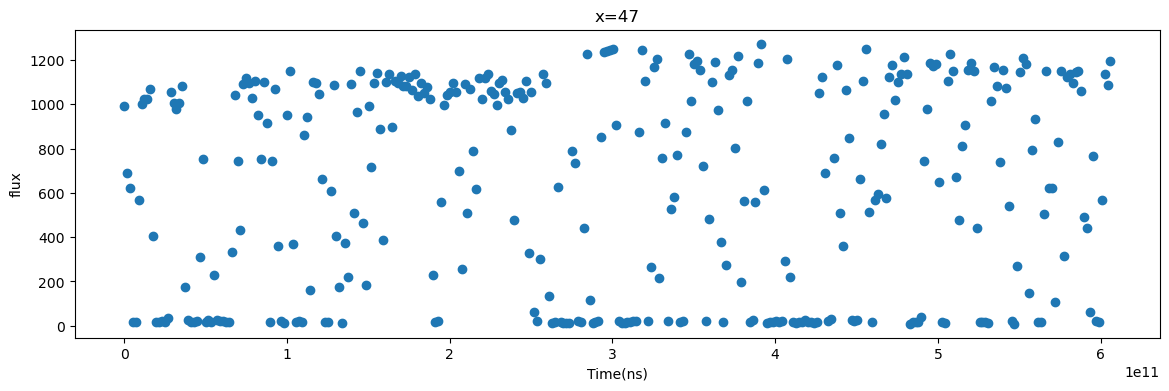

In [130]:
# verticle slice at center of ion 
plt.figure(figsize=(14,4))
plt.scatter(by[:-1],h[2])
plt.xlabel("Time(ns)")
plt.ylabel("flux")
plt.title("x=47")

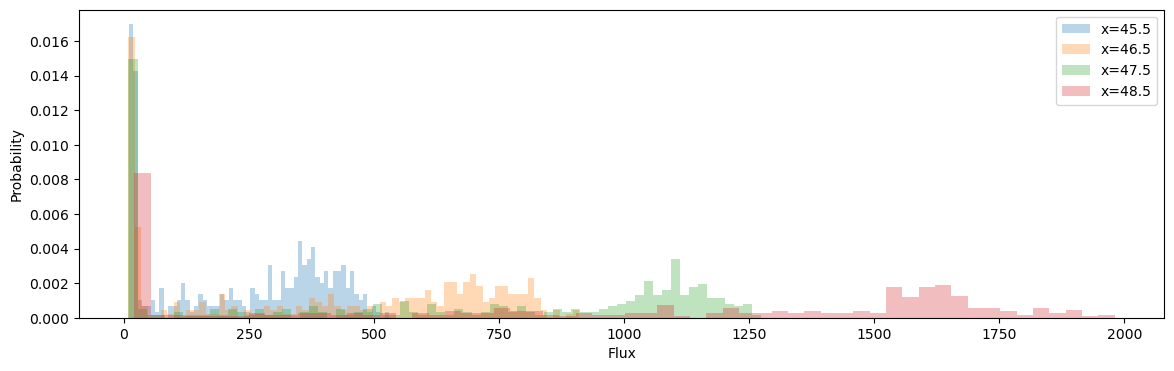

In [131]:
plt.figure(figsize=(14,4))
plt.hist(h[0],bins=60,alpha=0.3,density=True,label=("x=45.5"))
plt.hist(h[1],bins=70,alpha=0.3,density=True,label=("x=46.5"))
plt.hist(h[2],bins=70,alpha=0.3,density=True,label=("x=47.5"))
plt.hist(h[3],bins=60,alpha=0.3,density=True,label=("x=48.5"))

plt.xlabel("Flux")
plt.ylabel("Probability")
plt.legend()
plt.show()

### Section 3: 
Condition for bright: dt< threshold AND dt of next element also < threshold

In [239]:
bright,dark=ion_1.bright,ion_1.dark #bright and dark dataframes
dark.head(5) #first 10 values if "dark"

,index,y,x,time,center flux,cluster size,dt
8,8,93,48,1.237680e+07,800,4,2.531658e+06
22,22,93,46,2.605018e+07,2150,8,2.100702e+06
29,29,92,48,3.686888e+07,1250,4,2.393475e+06
31,31,92,47,3.908945e+07,1300,4,2.145497e+06
32,32,92,47,4.425189e+07,575,4,5.162439e+06


In [247]:
data=ion_1.dark.index #only the index values of dark 
data[:5] #illustrating data

Int64Index([8, 22, 29, 31, 32], dtype='int64')

#### The following function removes non-consequetive photon hits from the dark dataframe

In [248]:
def subset(array):
    keep=[] # keep in dark df
    to_rem=[] # remove from dark df and add to bright df
    for i,idx in enumerate (data):
        if (idx+1) in data or (idx-1) in data:      
            keep.append(idx)
        else: 
            to_rem.append(idx)
    return (keep,to_rem)

new=subset(data)
to_keep=new[0] # keep to dark df
to_remove=new[1] # add to bright df

##### Checking code

In [252]:
print (to_keep[:20])

[31, 32, 38, 39, 126, 127, 128, 158, 159, 164, 165, 174, 175, 176, 223, 224, 227, 228, 273, 274]


In [251]:
print (to_remove[:20])

[8, 22, 29, 44, 53, 64, 80, 91, 94, 96, 99, 110, 113, 119, 122, 132, 134, 148, 180, 182]


In [253]:
len(to_keep)+len(to_remove)-len(data) # checking redundancy 

0

In [256]:
len(to_keep)/len(dark)

0.290941324732469

70% reduction in dark region 

In [276]:
bright=ion_1.bright #original bright

In [277]:
sub_bright=One.data_table.query(f'index in {to_remove}')

In [280]:
bright=bright.append(sub_bright,verify_integrity=True)

In [286]:
bright.sort_values("index",inplace=True) # new bright

In [288]:
dark=dark.query(f'index in {to_keep}') # modified dark 
dark

,index,y,x,time,center flux,cluster size,dt
31,31,92,47,3.908945e+07,1300,4,2.145497e+06
32,32,92,47,4.425189e+07,575,4,5.162439e+06
38,38,91,47,5.067974e+07,1675,6,2.497961e+06
39,39,92,48,5.286766e+07,1675,6,2.187917e+06
126,126,92,49,1.567486e+08,1575,7,2.750117e+06
...,...,...,...,...,...,...,...
299558,299558,90,47,6.073915e+11,825,3,2.560150e+06
299559,299559,92,47,6.073938e+11,1525,5,2.225039e+06
299560,299560,92,48,6.073972e+11,2100,7,3.423427e+06
299703,299703,93,48,6.075524e+11,875,4,2.912936e+06


In [289]:
len(to_keep)  # validating lengths of df (just above) and of new dark indices

13621

##### Transition Points

In [296]:
transpts=[]
def transitions():
       
        misscount = 0
        self.transpts.clear()
        for i in range(len(One.data_table)) :
            if i not in bright['index']:
                misscount = misscount + 1
                if misscount == 1:
                    transpts.append(i)
            if i in bright['index'] and misscount >= 1:
                misscount = 0
                transpts.append(i)

In [297]:
len(t)/time  # Number of transitions throughout the experiment 

20.3452091318759

Acc to telegraph: ~ 100 transitions. This number seems too low.
